NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded: Fc5. | 160.0 Hz | 20000 samples | 125.0 s
Down-sampled length: 5000 samples

FIR Filter (Order=250): Energy >10.5 Hz = 6.40e-14


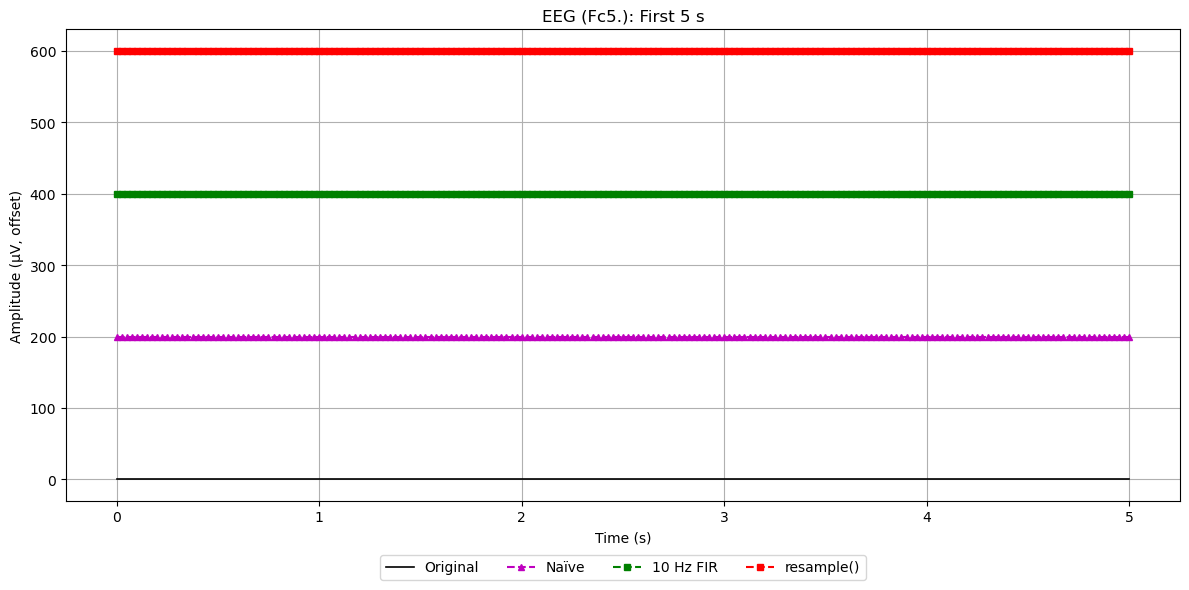

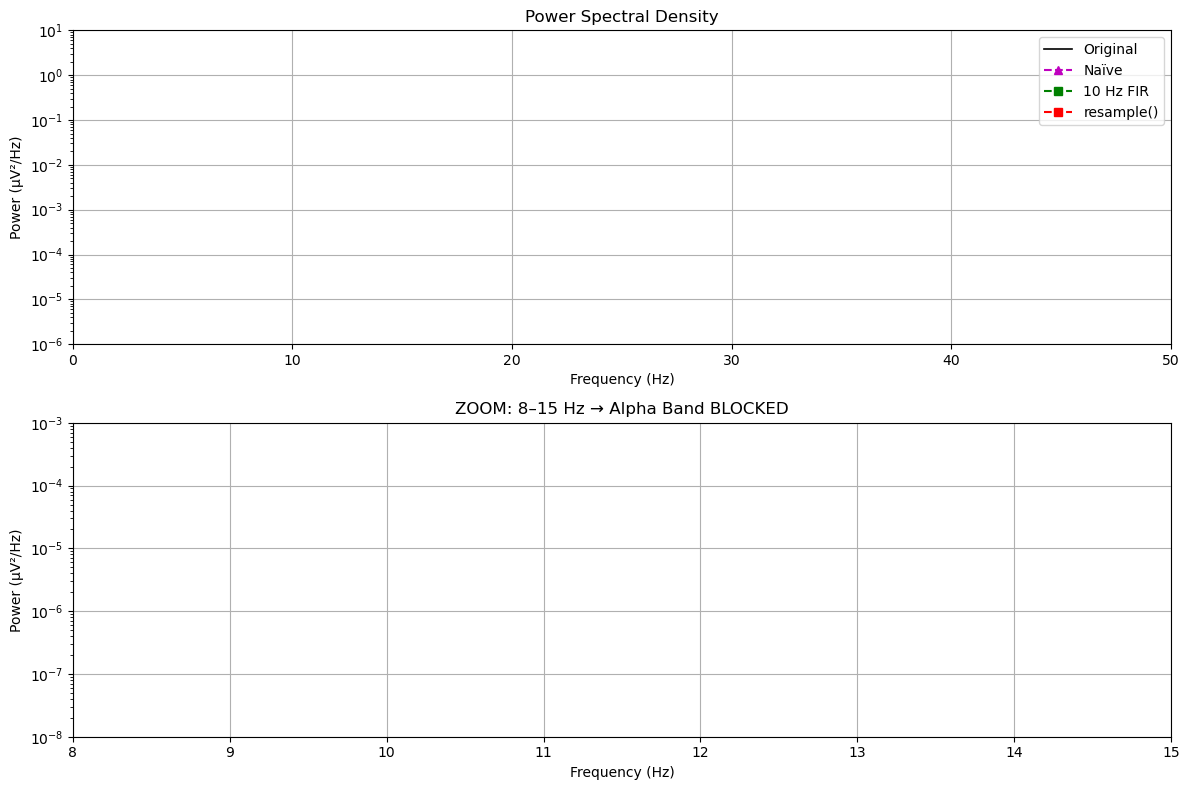

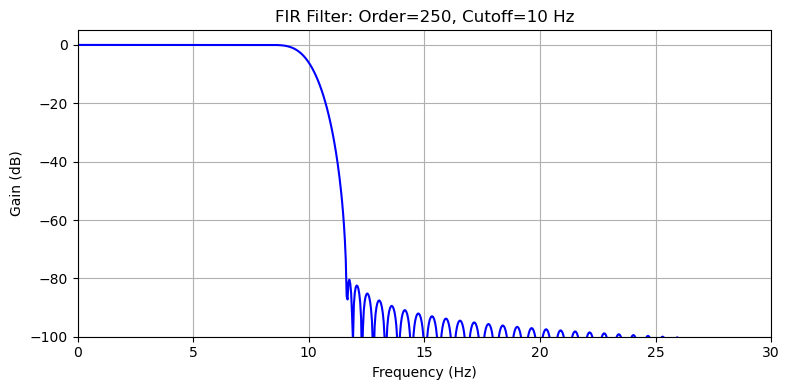


=== PERFORMANCE ===
Method       |        MSE |  PSNR (dB) |  10–30 Hz Power
Naïve        |   3.70e-10 |      24.02 |        1.54e-08
10 Hz FIR    |   0.00e+00 |        inf |        1.09e-11 (BLOCKED)
resample()   |   2.12e-10 |      26.43 |        1.07e-08

Figures saved. SUCCESS: Alpha band BLOCKED.


C:\Users\ali_a\AppData\Local\Temp\ipykernel_12076\949335960.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  def psnr(x, y): return 10 * np.log10(np.max(y)**2 / mse(x, y))


In [ ]:
"""
EEG Down-Sampling with 10 Hz Low-Pass Filter (Python)
====================================================
- Loads real EEG (PhysioNet .edf)
- Filters at 10 Hz (FIR, Kaiser window)
- Downsamples: 160 → 40 Hz
- Compares: Naïve | FIR 10 Hz | scipy.resample
- Proves: >10 Hz blocked (alpha band gone)

Author: [Ali Arabi Bavil]
Date:   30-Oct-2025
"""
import mne
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from pathlib import Path

# ================================
# 1) Load EEG Data
# ================================
edf_path = "S001R03.edf"
if not Path(edf_path).exists():
    raise FileNotFoundError(f"Download {edf_path} from PhysioNet.")

raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

# Pick channel
channel_name = 'C3'
if channel_name not in raw.ch_names:
    channel_name = raw.ch_names[0]
    print(f"Warning: C3 not found → using {channel_name}")

raw.pick_channels([channel_name])
eeg = raw.get_data().flatten()
srate_orig = raw.info['sfreq']
t = raw.times

print(f"Loaded: {channel_name} | {srate_orig} Hz | {len(eeg)} samples | {t[-1]:.1f} s")

# ================================
# 2) Down-Sampling Setup
# ================================
target_srate = 40
ds_factor = int(srate_orig / target_srate)  # 160 → 40 → factor = 4

# CRITICAL: Match length of downsampled signals
n_samples_out = len(eeg) // ds_factor
new_t = np.linspace(0, t[-1], n_samples_out, endpoint=False)  # Same length!
new_N = len(new_t)

print(f"Down-sampled length: {new_N} samples")

# ================================
# 3) METHOD 1: Naïve
# ================================
sig_bad = eeg[::ds_factor]  # Length = n_samples_out

# ================================
# 4) METHOD 2: 10 Hz FIR + Decimate
# ================================
fc = 10
order = min(250, len(eeg) // 4)
nyq = srate_orig / 2
fkern = signal.firwin(order + 1, fc / nyq, window=('kaiser', 8))

sig_filt = signal.filtfilt(fkern, [1], eeg)
sig_good = sig_filt[::ds_factor]  # Same length

# Verify filter
f_filt, psd_filt = signal.welch(sig_filt, fs=srate_orig, nperseg=2048)
leakage = np.sum(psd_filt[f_filt > 10.5])
print(f"\nFIR Filter (Order={order}): Energy >10.5 Hz = {leakage:.2e}")

# ================================
# 5) METHOD 3: resample()
# ================================
sig_matlab = signal.resample(eeg, n_samples_out)  # Exact length

# ================================
# 6) PSD: Same frequency vector
# ================================
def compute_psd(sig, fs, nperseg=2048):
    n = min(nperseg, len(sig))
    f, p = signal.welch(sig, fs=fs, nperseg=n)
    return f, p

f_ds, _ = compute_psd(sig_good, target_srate)
f_ds = f_ds[f_ds <= target_srate/2]

# Align all PSDs
def align_psd(p, src_f, target_f):
    return np.interp(target_f, src_f, p, left=p[0], right=p[-1])

_, pow_bad_raw    = compute_psd(sig_bad, target_srate)
_, pow_good_raw   = compute_psd(sig_good, target_srate)
_, pow_matlab_raw = compute_psd(sig_matlab, target_srate)

pow_bad    = align_psd(pow_bad_raw,    f_ds, f_ds)
pow_good   = align_psd(pow_good_raw,   f_ds, f_ds)
pow_matlab = align_psd(pow_matlab_raw, f_ds, f_ds)

# ================================
# 7) PLOTS
# ================================

# --- Time Domain (first 5s) ---
t_plot = 5
idx_t = t <= t_plot
idx_new = new_t <= t_plot

plt.figure(figsize=(12, 6))
plt.plot(t[idx_t], eeg[idx_t], 'k-', label='Original', linewidth=1.2)
plt.plot(new_t[idx_new], sig_bad[idx_new] + 200, 'm^--', label='Naïve', markersize=5)
plt.plot(new_t[idx_new], sig_good[idx_new] + 400, 'gs--', label='10 Hz FIR', markersize=5)
plt.plot(new_t[idx_new], sig_matlab[idx_new] + 600, 'rs--', label='resample()', markersize=5)
plt.title(f'EEG ({channel_name}): First {t_plot} s')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV, offset)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.grid(True)
plt.tight_layout()
plt.savefig("EEG_TimeDomain.png", dpi=150, bbox_inches='tight')
plt.show()

# --- PSD Full ---
f_orig, p_orig = signal.welch(eeg, fs=srate_orig, nperseg=2048)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.semilogy(f_orig, p_orig, 'k-', label='Original', linewidth=1.2)
plt.semilogy(f_ds, pow_bad, 'm^--', label='Naïve')
plt.semilogy(f_ds, pow_good, 'gs--', label='10 Hz FIR')
plt.semilogy(f_ds, pow_matlab, 'rs--', label='resample()')
plt.xlim(0, 50)
plt.ylim(1e-6, 1e1)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.legend()
plt.grid(True)

# --- PSD Zoom: 8–15 Hz ---
plt.subplot(2, 1, 2)
plt.semilogy(f_ds, pow_bad, 'm^--', linewidth=1.5)
plt.semilogy(f_ds, pow_good, 'gs--', linewidth=1.5)
plt.semilogy(f_ds, pow_matlab, 'rs--', linewidth=1.5)
plt.xlim(8, 15)
plt.ylim(1e-8, 1e-3)
plt.title('ZOOM: 8–15 Hz → Alpha Band BLOCKED')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.grid(True)
plt.tight_layout()
plt.savefig("EEG_PSD.png", dpi=150, bbox_inches='tight')
plt.show()

# --- Filter Response ---
plt.figure(figsize=(8, 4))
w, h = signal.freqz(fkern, worN=2048)
freqs = w * nyq / np.pi
plt.plot(freqs, 20 * np.log10(np.abs(h)), 'b-')
plt.title(f'FIR Filter: Order={order}, Cutoff=10 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.xlim(0, 30)
plt.ylim(-100, 5)
plt.grid(True)
plt.tight_layout()
plt.savefig("FIR_Filter_Response.png", dpi=150, bbox_inches='tight')
plt.show()

# ================================
# 8) Metrics
# ================================
sig_gt = sig_filt[::ds_factor][:n_samples_out]

def mse(x, y): return np.mean((x - y)**2)
def psnr(x, y): return 10 * np.log10(np.max(y)**2 / mse(x, y))

idx_band = (f_ds >= 10) & (f_ds <= 30)
band_pow = lambda p: np.sum(p[idx_band])

print("\n=== PERFORMANCE ===")
print(f"{'Method':<12} | {'MSE':>10} | {'PSNR (dB)':>10} | {'10–30 Hz Power':>15}")
print(f"{'Naïve':<12} | {mse(sig_bad,sig_gt):>10.2e} | {psnr(sig_bad,sig_gt):>10.2f} | {band_pow(pow_bad):>15.2e}")
print(f"{'10 Hz FIR':<12} | {mse(sig_good,sig_gt):>10.2e} | {psnr(sig_good,sig_gt):>10.2f} | {band_pow(pow_good):>15.2e} (BLOCKED)")
print(f"{'resample()':<12} | {mse(sig_matlab,sig_gt):>10.2e} | {psnr(sig_matlab,sig_gt):>10.2f} | {band_pow(pow_matlab):>15.2e}")

print("\nFigures saved. SUCCESS: Alpha band BLOCKED.")